In this homework, you need to solve two tasks. For problems with theoretical calculations, you need to show a sufficient number of intermediate steps to explain how you have obtained the result. Formulas are excepted only in Latex style inside the notebook. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). Overall, there are 45 points, however, you can get a maximum of 40 points for this assignment( `your_points = max(your_points, 40)`). No bonus points will be transferred to the next assignment.

# Task 1. Martian weather. (20 points)

In this task you need to estimate parameters and their confidence intervals for a given sample. As data, you will explore martian weather. For more visualizations look [here](https://pudding.cool/2018/01/mars-weather/).

First of all, you will need some libraries. Also, fix random seed to get reproducable results.

In [1]:
import numpy as np
from numpy.random import choice, seed
import pandas as pd
from scipy.stats import sem, norm, skew, chi2

import matplotlib.font_manager

import matplotlib.pyplot as plt
import matplotlib as mp


seed(366)

In [2]:
titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

mp.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
mp.rcParams['legend.handletextpad'] = 0.5
mp.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
mp.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
mp.rcParams['font.size'] = 12
mp.rcParams['font.family'] = 'serif'
mp.rcParams['font.serif'] = 'Times New Roman'
mp.rcParams['axes.labelsize'] = labelsize
mp.rcParams['axes.titlesize'] = titlesize
mp.rcParams['axes.unicode_minus'] = False

mp.rc('xtick', labelsize=xticksize)
mp.rc('ytick', labelsize=yticksize)
mp.rc('legend', fontsize=legendsize)

mp.rc('font', **{'family':'serif'})

## Part 1. Load data (1 point)

You need to load data from `mars-weather.csv`, take feature for your variant, remove absent values (`Nan`s) and convert sample to `int` type. 

### a) 

`feature_name = "min_temp"`

### b)

`feature_name = "max_temp"`

In [3]:
# Your code
feature_name = "min_temp"
df = pd.read_csv("mars-weather.csv")[feature_name]
sample_full = df.dropna().values.astype(np.int)

Let's take a quarter of martian year ~ 168 sols(martian days). Sample them randomly from full sample using function `choice`(from `numpy.random`) with parameter `replace=False`.

In [4]:
N = 168

sample_part = choice(sample_full, size=N, replace=False)

Plot values frequences for full and partial sample using bar plot.

Text(0, 0.5, 'Values of Min temperature')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


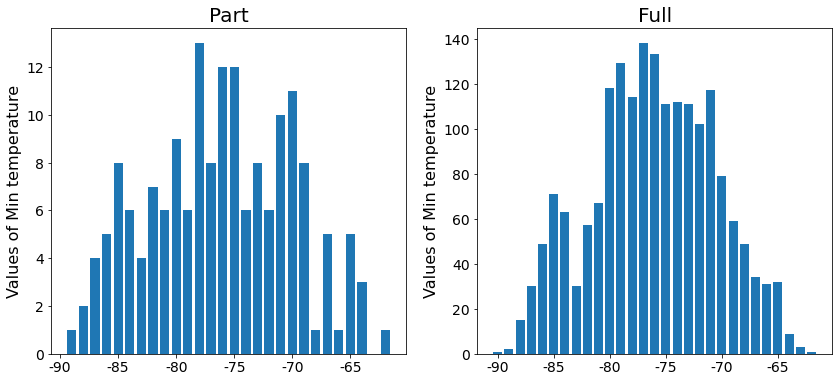

In [5]:
pval, pcount = np.unique(sample_part, return_counts=True)
fval, fcount = np.unique(sample_full, return_counts=True)

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.bar(pval, pcount)
plt.title("Part")
plt.ylabel("Frequency")
plt.ylabel("Values of Min temperature")

plt.subplot(122)
plt.bar(fval, fcount)
plt.title("Full");
plt.ylabel("Frequency")
plt.ylabel("Values of Min temperature")

## Part 2. Parameter estimation. (6 points)
Find the following parameters' estimates and their 95% confidence intervals (except for `mode` and `skewness`). You need to show theoretical calculations (with intermediate steps) for estimates and intervals (with intermediate steps) and then make simulation.

### a) Mean and CI

$$ \hat{mean} = ...$$

$$ CI(\hat{mean}) = ...$$

In [6]:
def mean_and_normal_confidence_interval(samples, alpha=0.05):
    
    z_alpha = norm.ppf(1 - alpha / 2)
    mean = np.mean(samples)
    se = sem(samples)
    
    return mean, (mean - z_alpha * se, mean + z_alpha * se)

In [7]:
mean, (lower, upper) = mean_and_normal_confidence_interval(sample_part)
f"Mean {mean:.3f} with confidence interval ({lower:.3f}, {upper:.3f})"

'Mean -76.161 with confidence interval (-77.095, -75.227)'

### b) Median and CI

Here you can assume that PDF is continuous at the median point and provide a normal-based interval.

$$ \hat{median} = ...$$

$$ CI(\hat{median}) = ...$$

In [8]:
def median_and_normal_confidence_interval(samples, alpha=0.05):
    
    z_alpha = norm.ppf(1 - alpha / 2)
    median = np.median(samples)
    uval, ucounts = np.unique(sample_part, return_counts=True)
    p = ucounts / ucounts.sum()
    f = p[uval == median][0]
    se = 0.5 / np.sqrt(len(sample_part)) / f
    
    return median, (median - z_alpha * se, median + z_alpha * se)

In [9]:
median, (lower, upper) = median_and_normal_confidence_interval(sample_part)
f"Median {median:.3f} with normal-based confidence interval ({lower:.3f}, {upper:.3f})"

'Median -76.000 with normal-based confidence interval (-77.059, -74.941)'

### c) Variance and CI


$$ \hat{Variance} = ...$$

$$ CI(\hat{Variance}) = ...$$

In [10]:
def variance_and_normal_confidence_interval(samples, alpha=0.05):
    
    n = len(samples)
    Sn = np.var(samples) * n
    lower, upper = chi2.ppf([alpha / 2, 1 - alpha / 2], n-1)
    return Sn / n, (Sn / lower, Sn / upper)

In [11]:
var, (lower, upper) = variance_and_normal_confidence_interval(sample_part)
f"Variance {var:.3f} with confidence interval ({lower:.3f}, {upper:.3f})"

'Variance 37.909 with confidence interval (47.845, 31.116)'

### d) Mode (most frequent value in a sample)

In [12]:
def mode_function(sample):
    uval, ucounts = np.unique(sample, return_counts=True)
    return uval[np.argmax(ucounts)]

In [13]:
mode = mode_function(sample_part)
f"Mode: {mode}"

'Mode: -78'

### e) Skewness

In [14]:
f"Skewness: {skew(sample_part):e}"

'Skewness: 1.214688e-02'

## Part 3. Bootstrap (4 points)

Find confidence intervals for following estimates using bootsrap. Use function `choice` with parameter `replace=True` for bootstrap sampling. Try different numbers of generated samples.

In [15]:
def get_bootstrap_variance(samples, func, nruns=100):
    n = len(samples)
    values = [func(choice(samples, size=n, replace=True)) for _ in range(nruns)]
    mean = np.mean(values)
    var = np.mean((values - mean)**2)
    return var

In [16]:
def estimate_and_bootstrap_normal_confidence_interval(samples, func, nruns=100, alpha=0.05):
    
    z_alpha = norm.ppf(1 - alpha / 2)
    value = func(samples)
    se = np.sqrt(get_bootstrap_variance(samples, func, nruns))
    
    return value, (value - z_alpha * se, value + z_alpha * se)

### a) Mean and CI

In [17]:
mean, (lower, upper) = estimate_and_bootstrap_normal_confidence_interval(sample_part, np.mean)
f"Mean {mean:.3f} with confident interval ({lower:.3f}, {upper:.3f})"

'Mean -76.161 with confident interval (-76.933, -75.388)'

### b) Median and CI

In [18]:
median, (lower, upper) = estimate_and_bootstrap_normal_confidence_interval(sample_part, np.median)
f"Median {median:.3f} with normal-based confident interval ({lower:.3f}, {upper:.3f})"

'Median -76.000 with normal-based confident interval (-77.188, -74.812)'

### c) Variance and CI

In [19]:
var, (lower, upper) = estimate_and_bootstrap_normal_confidence_interval(sample_part, np.var)
f"Variance {var:.3f} with confident interval ({lower:.3f}, {upper:.3f})"

'Variance 37.909 with confident interval (31.693, 44.125)'

## Part 4. Comparison with true values. (1 point)

Compare with estimates calculated over full sample. Write conclusion about estimates and their confidence intervals obtained without and with bootstrap. Also, you can share some conclusions about martian weather :)

In [20]:
funcs = [np.mean, np.median, np.var, mode_function, skew]
[f"{func.__name__.split('.')[-1]}: {func(sample_full):.3f}" for func in funcs]

['mean: -76.121',
 'median: -76.000',
 'var: 30.279',
 'mode_function: -77.000',
 'skew: -0.057']

## Part 5. Confidence intervals and sample size. (8 points)

Compare size of confidence intervals **for the mean** obtained without and with bootstrap. Additionally, compare an empirical coverage of different confidence intervals (by generating sufficient number of samples of corresponding size and calculating proportion of cases when the interval covers the mean of the whole data column). Consider sizes `[42, 84, 126, ..., 1344]`. Plot results and make conclution about their accuracy.

In [21]:
seed(476)
# sizes = [21, 42, 84, 168, 335, 670, 1340]
sizes = 42 * np.arange(1, 33)


In [22]:
results = np.empty((len(sizes), 2))
for i, N_i in enumerate(sizes): 
    sample_part = choice(sample_full, size=N_i, replace=False)
    
    mean, (lower, upper) = mean_and_normal_confidence_interval(sample_part)
    results[i, 0] = upper - lower
    
    mean, (lower, upper) = estimate_and_bootstrap_normal_confidence_interval(sample_part, np.mean, nruns=1000)
    results[i, 1] = upper - lower

Text(0, 0.5, 'CI size')

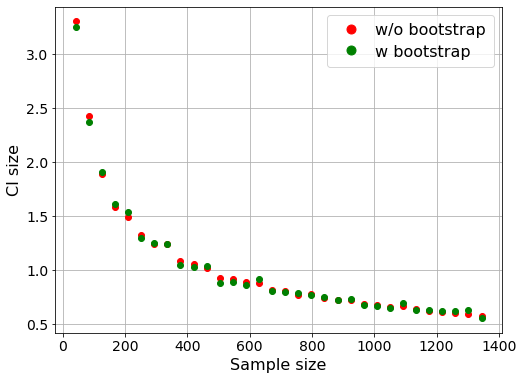

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(sizes, results[:, 0], "ro", label="w/o bootstrap")
plt.plot(sizes, results[:, 1], "go", label="w bootstrap")
plt.grid(True)
plt.legend()
plt.xlabel("Sample size")
plt.ylabel("CI size")

# Task 2. Currency in RC-circuit. (25 points)

In this part you need to estimate parameters and apply delta method. 

First of all, you will need some libraries. Also, fix random seed to get reproducable results.

In [24]:
import numpy as np
from scipy.stats import norm, uniform
from numpy.random import choice, seed

seed(100)

## Part 1. Estimate parameters. (4 points)

Assume that there is aт RC-circuit with a capacitor and a resistor. 
<img src="circuit.png" width="200"  class="center">

We charge the capacitor until it reaches voltage $V$ and measure current intensity. In this case voltage on the capacitor yields the formula for exponential decay:

$$ V_C(t) = V e^{-\frac{t}{RC}} $$

Let's assume that voltage $V$ and resistence $R$ are independent and belong to the following distributions:

### a) 
$V \sim N(5, 1)$, 

$R \sim Uniform(5, 10)$

### b) 
$V \sim N(15, 3)$, 

$R \sim Exp(20)$

Consider **true values** for $V$ and $R$ to be the means of the corresponding distributions.

Generate sample for $V$ of size 100. Apply maximum likelihood to estimate the mean. Show theoretical calculations for the estimates (with intermediate steps) and make simulation.

$$\hat{V_{mean}} = ...$$

In [25]:
size = 10
V_mean = 5
V_sigma = 1

V_sample = norm.rvs(loc=V_mean, scale=V_sigma, size=size)

In [26]:
V_mean_est = V_sample.mean()
V_sigma_est = np.mean((V_sample - V_mean_est)**2)
f"Mean: {V_mean_est:.4f}, SE: {V_sigma_est:.4f}"

'Mean: 5.0206, SE: 0.7090'

Generate sample for $R$ on size 100. Apply maximum likelihood to estimate the mean. Show theoretical calculations for estimates (with intermediate steps) and make simulation.

In [42]:
R_min = 5
R_max = 10

R_sample = uniform.rvs(loc=R_min, scale=R_max - R_min, size=size)

In [44]:
R_mean_est = (np.max(R_sample) + np.min(R_sample)) / 2.
f"Mean: {R_mean_est/2:.4f}"

'Mean: 3.7500'

## Part 2. Apply delta method. (8 points)

Assume, that we measure current intensity after 1 second. Let's take $C = 1$. In this case we get the following simplified formula:

$$ I = \frac{V}{R} e^{-\frac{1}{R}} $$

Find estimate for current and it's confidence interval. Show theoretical calculations for estimates (with intermediate steps) and make simulation.

$$\hat{I} = ...$$

$$ CI(\hat{I}) = ...$$

Результат для случая R - равномерное
![Результат для равномерного случая](task2_formulas.png)
Результат для случая R - экспоненциальное
![Результат для равномерного случая](task2_formulas2.png)
![Результат для равномерного случая](task2_formulas3.png)

In [29]:
n = size
theta = R_max_est
sigma = V_sigma
V0 = V_mean_est
R0 = R_max_est
I = 1./n * np.diag([sigma**2, theta**2])
g = np.array([2 / R0 * np.exp(-2 / R0), -2 * V0 / R0**3 * np.exp(-2 / R0) * (R0 - 2), ]).reshape(-1, 1)

In [30]:
se = np.sqrt(g.T@I@g).item()
f"SE for delta method: {se:e}"

'SE for delta method: 2.169314e-01'

## Part 3. Non-parametric bootstrap estimation. (2 points)

Estimate confidence interval for $I$ using non-parametric bootstrap.

In [31]:
def get_nonparametric_bootstrap_variance(V_sample_original, R_sample_original, nruns=1000):
    V_n = len(V_sample_original)
    R_n = len(R_sample_original)
    V_values = np.array([np.mean(choice(V_sample_original, size=V_n, replace=True)) for _ in range(nruns)])
    R_values = np.array([0.5*np.max(choice(R_sample_original, size=R_n, replace=True)) for _ in range(nruns)])
    values = 2 * V_values / R_values * np.exp(-2 / R_values)
    mean = np.mean(values)
    var = np.mean((values - mean)**2)
    return var

In [32]:
se = np.sqrt(get_nonparametric_bootstrap_variance(V_sample, R_sample))
f"SE for non-parametric bootstrap: {se:e}"

'SE for non-parametric bootstrap: 9.062277e-02'

## Part 4. Parametric bootstrap estimation. (3 points)

Estimate confidence interval for $I$ using parametric bootstrap.

In [33]:
def get_parametric_bootstrap_variance(V_sample_original, R_sample_original, nruns=1000):
    V_mean = np.mean(V_sample_original)
    V_std = np.std(V_sample_original)
    V_n = len(V_sample_original)

    R_max = np.max(R_sample_original)
    R_n = len(R_sample_original)


    V_values = np.array([np.mean(norm.rvs(loc=V_mean, scale=V_sigma, size=V_n)) for _ in range(nruns)])
    R_values = np.array([np.mean(uniform.rvs(scale=R_max, size=R_n)) for _ in range(nruns)])
    values = V_values / R_values * np.exp(-1 / R_values)
    mean = np.mean(values)
    var = np.mean((values - mean)**2)
    return var

In [34]:
se = np.sqrt(get_parametric_bootstrap_variance(V_sample, R_sample))
f"SE for parametric bootstrap: {se:e}"

'SE for parametric bootstrap: 1.437596e-01'

## Part 5. Compare results. (8 points)

Compare size of confidence intervals obtained using delta method, parametric and non-parametric bootstrap. Additionally, compare an empirical coverage of different confidence intervals (by generating sufficient number of samples of corresponding size and calculating proportion of cases when the interval covers the true value for the current $I$). Consider sizes `[1e1, ..., 1e4]`. Plot results and make conclution about their accuracy.

In [35]:
sizes = np.logspace(2, 5, 4).astype(np.int)

In [36]:
results = np.empty((len(sizes), 3))

for s, size in enumerate(sizes):

    V_sample = norm.rvs(loc=V_mean, scale=V_sigma, size=size)
    R_sample = uniform.rvs(scale=R_max, size=size)

    n = size
    theta = R_max_est
    sigma = V_sigma
    V0 = V_mean_est
    R0 = R_max_est
    I = 1./n * np.diag([sigma**2, theta**2])
    g = np.array([2 / R0 * np.exp(-2 / R0), -2 * V0 / R0**3 * np.exp(-2 / R0) * (R0 - 2), ]).reshape(-1, 1)
    se = np.sqrt(g.T@I@g).item()
    results[s, 0] = se
    se = np.sqrt(get_nonparametric_bootstrap_variance(V_sample, R_sample))
    results[s, 1] = se
    se = np.sqrt(get_parametric_bootstrap_variance(V_sample, R_sample))
    results[s, 2] = se

Text(0, 0.5, 'CI size')

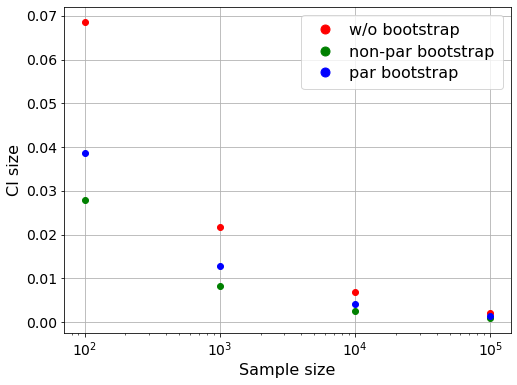

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(sizes, results[:, 0], "ro", label="w/o bootstrap")
plt.plot(sizes, results[:, 1], "go", label="non-par bootstrap")
plt.plot(sizes, results[:, 2], "bo", label="par bootstrap")
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.xlabel("Sample size")
plt.ylabel("CI size")